In [1]:
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#load the data
with h5py.File('data/background_for_training.h5', 'r') as f:
    X = f['Particles'][:100000]

print("Raw shape:", X.shape)

# Flatten per event
X = X.reshape(X.shape[0], -1)
X = np.nan_to_num(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype(np.float32)

X_tensor = torch.tensor(X_scaled).to(device)
input_dim = X_tensor.shape[1]
print("Processed shape:", X_tensor.shape)

Raw shape: (100000, 19, 4)
Processed shape: torch.Size([100000, 76])


In [6]:
#vae model
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 2 * latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
        self.latent_dim = latent_dim

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        # ✅ Clamp logvar to avoid extreme latent variance
        logvar = torch.clamp(logvar, -6, 6)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar, z

In [7]:
#disco loss
def disco_loss(x, y):
    x = x - x.mean(0)
    y = y - y.mean(0)
    a = torch.cdist(x, x)
    b = torch.cdist(y, y)
    A = a - a.mean(0) - a.mean(1, keepdim=True) + a.mean()
    B = b - b.mean(0) - b.mean(1, keepdim=True) + b.mean()
    dcov = (A * B).mean()
    dvar_x = (A * A).mean().sqrt()
    dvar_y = (B * B).mean().sqrt()
    return dcov / (dvar_x * dvar_y + 1e-10)

#vae loss
def vae_loss(x, x_hat, mu, logvar):
    recon = F.mse_loss(x_hat, x, reduction='mean')
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kl_div

In [9]:
#params
latent_dim = 16
learning_rate = 1e-3
batch_size = 256
epochs = 100
lambda_disco = 1000

#get vae parameters
vae_1 = VAE(input_dim, latent_dim).to(device)
vae_2 = VAE(input_dim, latent_dim).to(device)

#optimize with adam
optimizer = torch.optim.Adam(list(vae_1.parameters()) + list(vae_2.parameters()), lr=learning_rate)

#lists for plotting
loss_list, vae_1_list, vae_2_list, disco_list = [], [], [], []

In [10]:
#training loop
for epoch in range(epochs):
    
    perm = torch.randperm(X_tensor.size(0))
    total_loss, total_disco, total_vae1, total_vae2 = 0, 0, 0, 0

    for i in range(0, X_tensor.size(0), batch_size):
        x_batch = X_tensor[perm[i:i+batch_size]]

        out_1 = vae_1(x_batch)
        out_2 = vae_2(x_batch)

        x_reco_1, mu1, logvar1, z1 = out_1
        x_reco_2, mu2, logvar2, z2 = out_2

        loss1 = vae_loss(x_batch, x_reco_1, mu1, logvar1)
        loss2 = vae_loss(x_batch, x_reco_2, mu2, logvar2)
        disco = disco_loss(z1, z2)

        loss = loss1 + loss2 + lambda_disco * disco

        optimizer.zero_grad()
        loss.backward()

        #gradient clipping
        torch.nn.utils.clip_grad_norm_(list(vae_1.parameters()) + list(vae_2.parameters()), max_norm=5.0)

        optimizer.step()

        total_loss += loss.item()
        total_disco += disco.item()
        total_vae1 += loss1.item()
        total_vae2 += loss2.item()

    print(f"Epoch {epoch+1}/{epochs} "
          f"Loss={total_loss:.2e} VAE1={total_vae1:.2e} VAE2={total_vae2:.2e} DisCo={total_disco:.2f}")

    loss_list.append(total_loss)
    vae_1_list.append(total_vae1)
    vae_2_list.append(total_vae2)
    disco_list.append(total_disco)

Epoch 1/100 Loss=2.69e+04 VAE1=1.03e+03 VAE2=1.08e+03 DisCo=24.81
Epoch 2/100 Loss=8.02e+03 VAE1=1.14e+03 VAE2=1.15e+03 DisCo=5.72
Epoch 3/100 Loss=7.68e+03 VAE1=1.14e+03 VAE2=1.12e+03 DisCo=5.42
Epoch 4/100 Loss=7.84e+03 VAE1=1.14e+03 VAE2=1.12e+03 DisCo=5.58
Epoch 5/100 Loss=7.65e+03 VAE1=1.13e+03 VAE2=1.12e+03 DisCo=5.40
Epoch 6/100 Loss=7.57e+03 VAE1=1.13e+03 VAE2=1.13e+03 DisCo=5.31
Epoch 7/100 Loss=7.70e+03 VAE1=1.12e+03 VAE2=1.12e+03 DisCo=5.45
Epoch 8/100 Loss=7.71e+03 VAE1=1.12e+03 VAE2=1.12e+03 DisCo=5.47
Epoch 9/100 Loss=7.75e+03 VAE1=1.11e+03 VAE2=1.12e+03 DisCo=5.52
Epoch 10/100 Loss=7.46e+03 VAE1=1.10e+03 VAE2=1.12e+03 DisCo=5.24
Epoch 11/100 Loss=7.70e+03 VAE1=1.10e+03 VAE2=1.12e+03 DisCo=5.48
Epoch 12/100 Loss=7.65e+03 VAE1=1.10e+03 VAE2=1.11e+03 DisCo=5.43
Epoch 13/100 Loss=7.54e+03 VAE1=1.10e+03 VAE2=1.11e+03 DisCo=5.34
Epoch 14/100 Loss=7.72e+03 VAE1=1.10e+03 VAE2=1.11e+03 DisCo=5.51
Epoch 15/100 Loss=7.24e+03 VAE1=1.10e+03 VAE2=1.11e+03 DisCo=5.04
Epoch 16/100 Loss=

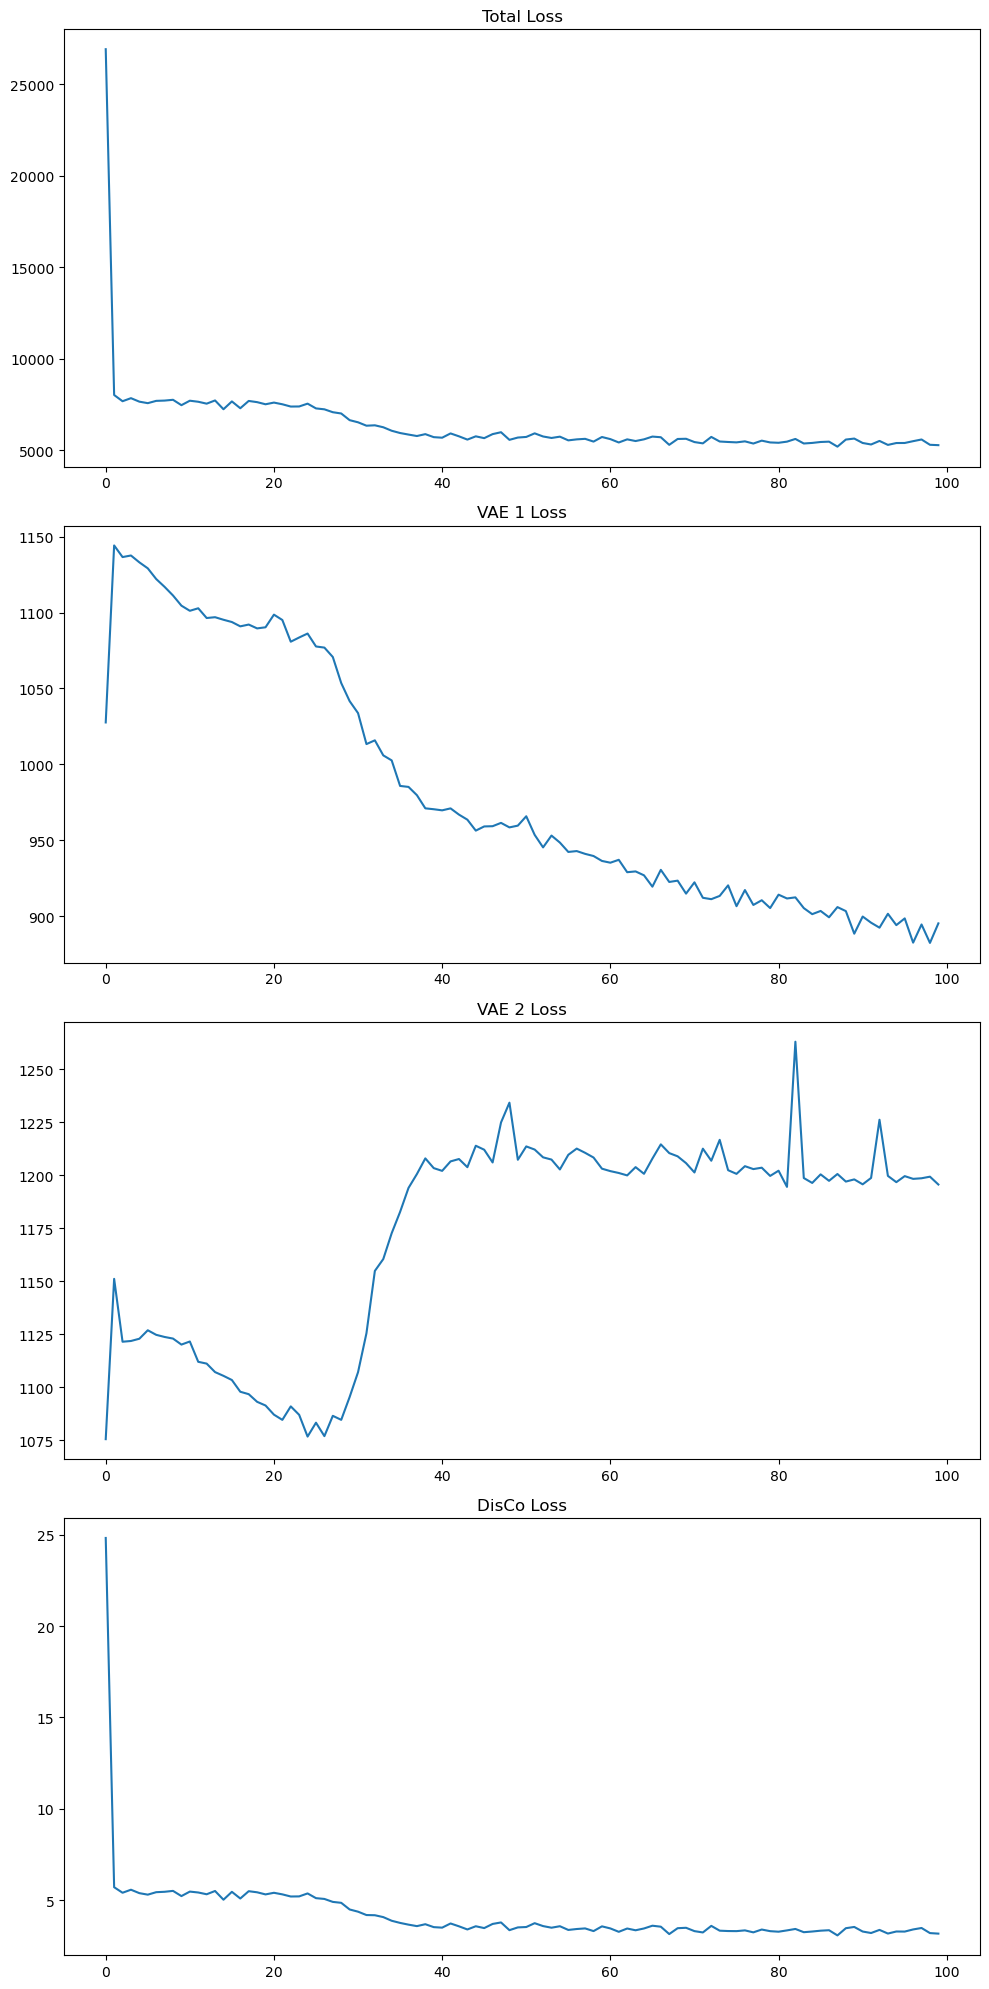

In [11]:
#plot the losses
plt.figure(figsize=(10, 20))

plt.subplot(4, 1, 1)
plt.plot(loss_list)
plt.title('Total Loss')

plt.subplot(4, 1, 2)
plt.plot(vae_1_list)
plt.title('VAE 1 Loss')

plt.subplot(4, 1, 3)
plt.plot(vae_2_list)
plt.title('VAE 2 Loss')

plt.subplot(4, 1, 4)
plt.plot(disco_list)
plt.title('DisCo Loss')

plt.tight_layout()
plt.show()